In [1]:
# Set environmental variables with google service credentials
import os
%env GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

env: GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json


In [2]:
# import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery

bqclient = bigquery.Client()

In [3]:
# Test BQ Connect
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[]


In [4]:
# Download query results.
forecast_autocorr = """
WITH actual AS (
    SELECT 
        DATE_TRUNC(date, month) AS year_month,
        SUM(sale_dollars) AS actual_total_sales
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    GROUP BY 1
    ORDER BY 1
)
SELECT 
    year_month,
    actual_total_sales
FROM actual
ORDER BY 1
"""

forecast_autocorr = (
    bqclient.query(forecast_autocorr)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [8]:
forecast_autocorr['year_month'] = pd.to_datetime(forecast_autocorr['year_month'], format='%Y-%m-%d')
forecast_autocorr.set_index('year_month', inplace=True)

In [10]:
forecast_autocorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   year_month          117 non-null    datetime64[ns]
 1   actual_total_sales  117 non-null    float64       
 2   model_total_sales   116 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.9 KB


In [21]:
# Compute and print the autocorrelation of monthly changes
autocorrelation_monthly = forecast_autocorr['actual_total_sales'].autocorr()
print("The autocorrelation of monthly sales is %4.2f" %(autocorrelation_monthly))

The autocorrelation of monthly sales is 0.56


In [24]:
# Convert the daily data to annual data
yearly_sales = forecast_autocorr.resample(rule='A').last()

# Repeat above for annual data
autocorrelation_yearly = yearly_sales['actual_total_sales'].autocorr()
print("The autocorrelation of annual sales is %4.2f" %(autocorrelation_yearly))

The autocorrelation of annual sales is 0.70


[1.         0.53968811 0.64367445 0.50956663 0.46900781 0.51337296
 0.58755502 0.44833053 0.43824826 0.4039521  0.47885285 0.41969539
 0.68500472 0.31618879 0.44031932 0.24884432 0.25919459 0.31610078
 0.32159375 0.23821104 0.2701036 ]


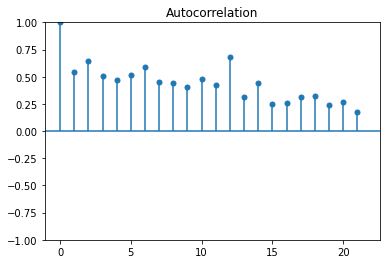

In [26]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Compute the acf array of HRB
acf_array = acf(forecast_autocorr['actual_total_sales'])
print(acf_array)

# Plot the acf function
plot_acf(forecast_autocorr['actual_total_sales'], alpha=1)
plt.show()

### We can see that a 12 month lag has the strongest autocorrelation in our dataset. Similar observation with we resampled to annual data for forecast.

The approximate confidence interval is +/- 0.18


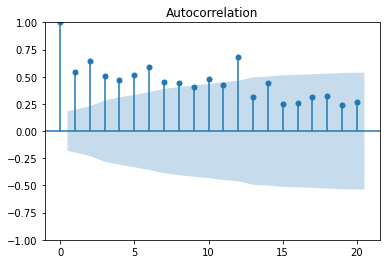

In [29]:
# Import the plot_acf module from statsmodels and sqrt from math
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

# Compute and print the autocorrelation of MSFT weekly returns
autocorrelation = forecast_autocorr['actual_total_sales'].autocorr()

# Find the number of observations by taking the length of the returns DataFrame
num_obs = len(forecast_autocorr)

# Compute the approximate confidence interval
conf = 1.96/sqrt(num_obs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(forecast_autocorr['actual_total_sales'], alpha=0.05, lags=20)
plt.show()

In [ ]:
# Download query results.
forecast_lag_12 = """
WITH actual AS (
    SELECT 
        DATE_TRUNC(date, month) AS year_month,
        SUM(sale_dollars) AS actual_total_sales
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    GROUP BY 1
    ORDER BY 1
),
forecast AS (
    SELECT
        year_month,
        actual_total_sales,
        LAG(actual_total_sales, 12) OVER (ORDER BY year_month) AS model_total_sales
    FROM actual
    ORDER BY 1
)
SELECT 
    year_month,
    actual_total_sales,
    model_total_sales,
FROM forecast
ORDER BY 1
"""

forecast_autocorr = (
    bqclient.query(forecast_autocorr)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

### We observe that the lag 12 autocorrelation of 0.70 is also statistically significant (outside of CI area)